# Database-style Operations on Dataframes

## About the data

In this notebook, we will using daily weather data that was taken from the National Centers for Environmental Information (NCEI) API. The data collection notebook contains
the process that was followed to collect the data.

Note: The NCEI is part of the National Oceanic and Atmospheric Administration (NOAA) and, as you can see from the URL for the API, this resource was created when the
NCEI was called the NCDC. Should the URL for this resource change in the future, you can search for the NCEI weather API to find the updated one

## Background on the data

Data meanings:
- RCP : precipitation in millimeters
- SNOW : snowfall in millimeters
- SNWD : snow depth in millimeters
- TMAX : maximum daily temperature in Celsius
- TMIN : minimum daily temperature in Celsius
- TOBS : temperature at time of observation in Celsius
- WESF : water equivalent of snow in millimeters

## Setup

In [ ]:
import pandas as pd # initializing Pandas

weather = pd.read_csv('/content/nyc_weather_2018.csv')
weather.head()

## Querying DataFrames

The query() method is an easier way of filtering based on some criteria. For example, we can use it to find all entries where snow was recorded

In [ ]:
# query like in the SQL/Dabase Manaagement system. SELECT * FROM * WHERE (conditions met)
snow_data = weather.query('datatype == "SNOW" and value > 0')
snow_data.head()

This is equivalent to quering the data/weather.db SQLite database for SELECT * FROM weather WHERE datatype == "SNOW" AND value > 0 :

In [ ]:
import sqlite3

# an effiecient way to connect into your database, with this you can safely rewrite your databasse if theirs already a file
with sqlite3.connect('/content/weather.db') as connection:
  snow_data_from_db = pd.read_sql(
      'SELECT * FROM weather WHERE datatype == "SNOW" AND value > 0',
      connection
  )

In [ ]:
snow_data.reset_index().drop(columns='index').equals(snow_data_from_db)

Note this is also equivalent to creating Boolean masks:

In [ ]:
weather[(weather.datatype == 'SNOW') & (weather.value > 0)].equals(snow_data) # Boolean mask are also a way to get yyour desired query

## Merging DataFrames

We have data for many different stations each day; however, we don't know what the stations are just their IDs. We can join the data in the data/weather_stations.csv
file which contains information from the stations endpoint of the NCEI API. Consult the weather_data_collection.ipynb notebook to see how this was collected. It looks like this:

In [ ]:
station_info = pd.read_csv('/content/weather_stations.csv')
station_info.head()

As a reminder, the weather data looks like this:

In [ ]:
weather.head()

We can join our data by matching up the station_info.id column with the weather.station column. Before doing that though, let's see how many unique values we
have:

In [ ]:
station_info.id.describe()

While station_info has one row per station, the weather dataframe has many entries per station. Notice it also has fewer uniques:

In [ ]:
weather.station.describe()

When working with joins, it is important to keep an eye on the row count. Some join types will lead to data loss:

In [ ]:
station_info.shape[0], weather.shape[0]

Since we will be doing this often, it makes more sense to write a function:

In [ ]:
def get_row_count(*dfs):
  return [df.shape[0] for df in dfs]
get_row_count(station_info, weather)

The map() function is more efficient than list comprehensions. We can couple this with getattr() to grab any attribute for multiple dataframes:

In [ ]:
def get_info(attr, *dfs):
  return list(map(lambda x: getattr(x, attr), dfs))
get_info('shape', station_info, weather)

By default merge() performs an inner join. We simply specify the columns to use for the join. The left dataframe is the one we call merge() on, and the right one is
passed in as an argument:

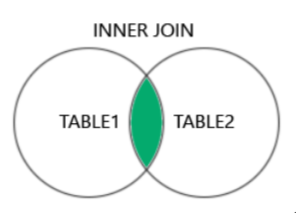

In [ ]:
inner_join = weather.merge(station_info, left_on='station',
                           right_on='id')
inner_join.sample(5, random_state=0)

We can remove the duplication of information in the station and id columns by renaming one of them before the merge and then simply using on :

In [ ]:
weather.merge(station_info.rename(dict(id='station'), axis=1),
              on='station').sample(5, random_state=0)

We are losing stations that don't have weather observations associated with them, if we don't want to lose these rows, we perform a right or left join instead of the inner join:

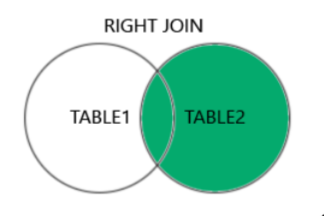

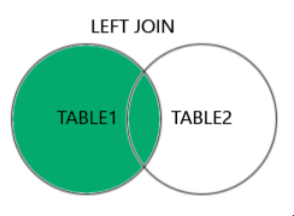

In [ ]:
left_join = station_info.merge(weather, left_on='id',
                              right_on='station', how='left')
right_join = weather.merge(station_info, left_on='station',
                           right_on='id', how='right')
right_join.tail()

The left and right join as we performed above are equivalent because the side that we kept the rows without matches was the same in both cases:

In [ ]:
left_join.sort_index(
    axis=1).sort_values(
        ['date', 'station']).reset_index().drop(
            columns='index').equals(

right_join.sort_index(
    axis=1).sort_values(
        ['date', 'station']).reset_index().drop(
            columns='index')
)

Note we have additional rows in the left and right joins because we kept all the stations that didn't have weather observations:

In [ ]:
get_info('shape', inner_join, left_join, right_join)

If we query the station information for stations that have NY in their name, believing that to be all the stations that record weather data for NYC and perform an outer join, we
can see where the mismatches occur:

In [ ]:
outer_join = weather.merge(
  station_info[station_info.name.str.contains('NY')],
  left_on='station', right_on='id', how='outer', indicator=True
)
outer_join.sample(
    4, random_state=0).append(
        outer_join[outer_join.station.isna()].head(2))

These joins are equivalent to their SQL counterparts. Below is the inner join. Note that to use equals() you will have to do some manipulation of the dataframes to line
them up:

In [ ]:
import sqlite3
with sqlite3.connect('/content/weather.db') as connection:
  inner_join_from_db = pd.read_sql(
  'SELECT * FROM weather JOIN stations ON weather.station == stations.id',
  connection
  )

inner_join_from_db.shape == inner_join.shape #checking is the tables are equals

Revisit the dirty data from the previous module.

In [ ]:
dirty_data = pd.read_csv(
  '/content/dirty_data.csv', index_col='date'
).drop_duplicates().drop(columns='SNWD')
dirty_data.head()

We need to create two dataframes for the join. We will drop some unecessary columns as well for easier viewing:

In [ ]:
valid_station = dirty_data.query('station != "?"').copy().drop(
    columns=['WESF', 'station'])
station_with_wesf = dirty_data.query('station == "?"').copy().drop(
    columns=['station', 'TOBS', 'TMIN', 'TMAX'])

Our column for the join is the index in both dataframes, so we must specify left_index and right_index :

In [ ]:
valid_station.merge(
  station_with_wesf, left_index=True, right_index=True
).query('WESF > 0').head()

The columns that existed in both dataframes, but didn't form part of the join got suffixes added to their names: _x for columns from the left dataframe and _y for columns
from the right dataframe. We can customize this with the suffixes argument:

In [ ]:
valid_station.merge(
station_with_wesf, left_index=True, right_index=True, suffixes=(
    '', '_?')
).query('WESF > 0').head()

Since we are joining on the index, an easier way is to use the join() method instead of merge() . Note that the suffix parameter is now lsuffix for the left dataframe's
suffix and rsuffix for the right one's:

In [ ]:
valid_station.join(
    station_with_wesf, rsuffix='_?').query('WESF > 0').head()

Joins can be very resource-intensive, so it's a good idea to figure out what type of join you need using set operations before trying the join itself. The pandas set operations
are performed on the index, so whichever columns we will be joining on will need to be the index. Let's go back to the weather and station_info dataframes and set
the station ID columns as the index:

In [ ]:
weather.set_index('station', inplace=True)
station_info.set_index('id', inplace=True)

The intersection will tell us the stations that are present in both dataframes. The result will be the index when performing an inner join:

In [ ]:
weather.index.intersection(station_info.index)

The set difference will tell us what we lose from each side. When performing an inner join, we lose nothing from the weather dataframe:

In [ ]:
weather.index.difference(station_info.index)

In [ ]:
station_info.index.difference(weather.index)

The symmetric difference will tell us what gets lost from both sides. It is the combination of the set difference in both directions:

In [ ]:
ny_in_name = station_info[station_info.name.str.contains('NY')]
ny_in_name.index.difference(weather.index).shape[0]\
+ weather.index.difference(ny_in_name.index).shape[0]\
== weather.index.symmetric_difference(ny_in_name.index).shape[0]

The union will show us everything that will be present after a full outer join. Note that since these are sets (which don't allow duplicates by definition), we must pass unique
entries for union:

In [ ]:
weather.index.unique().union(station_info.index)

Note that the symmetric difference is actually the union of the set differences:

In [ ]:
ny_in_name = station_info[station_info.name.str.contains('NY')]
ny_in_name.index.difference(weather.index).union(
    weather.index.difference(ny_in_name.index)).equals(
weather.index.symmetric_difference(ny_in_name.index)
)